# UK death data analysis

Analysis of UK death data based on a model with a stochastic reporting bias based on a dirichlet prior, as well as an unknown, time-varying Rt value.

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'
plt.style.use('default')

from periodic_sampling.synthetic_data import RenewalModel

In [2]:
uk_df = pd.read_csv("input_data.csv")


uk_df["Date"] = pd.to_datetime(uk_df["date"], format = "%Y-%m-%d")
uk_df.sort_values(by="Date", inplace=True); 
uk_df.index = uk_df.index.sort_values()
uk_df = uk_df[uk_df["Date"] < "2022-02-01"]
time_steps = uk_df.shape[0]

0.0


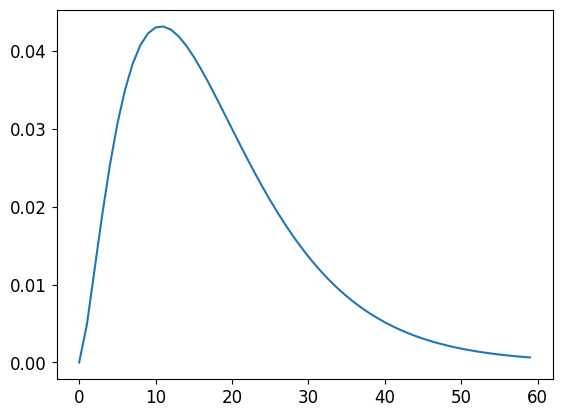

In [3]:
vals = [ss.gamma.pdf(x, a = 2.5, scale = 1/0.14) for x in range(60)]
plt.plot(range(60), vals);
print(vals[0])

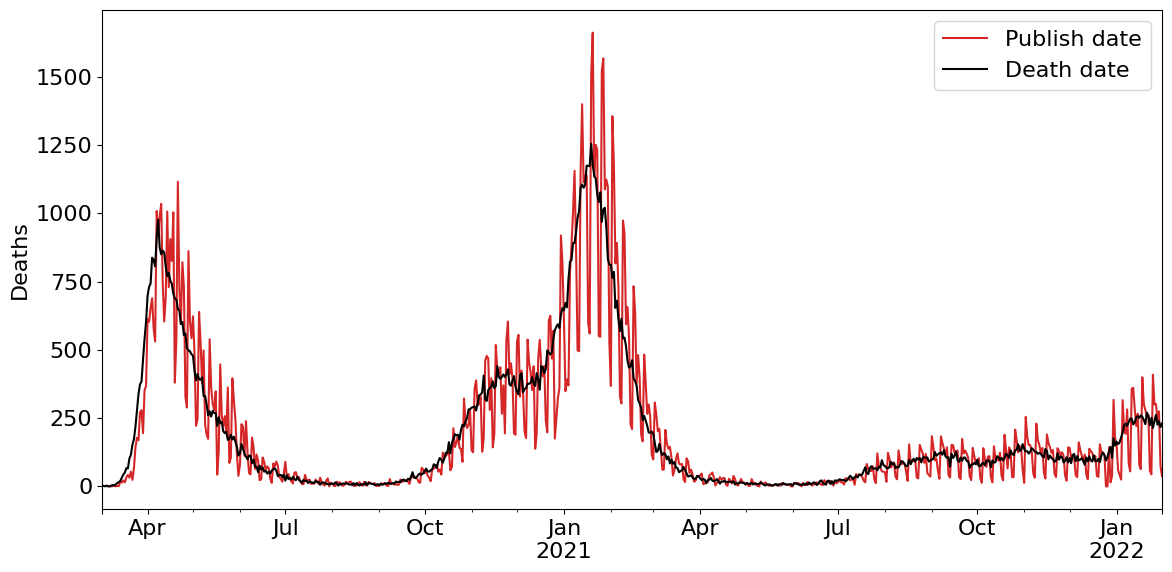

In [4]:
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(1, 1, figsize=(12,6))


plot2 = uk_df.plot.line('Date', 'newDeaths28DaysByPublishDate', ax=ax, color='tab:red', label = 'Publish date')
plot2 = uk_df.plot.line('Date', 'newDeaths28DaysByDeathDate', ax=ax, color='black', label = 'Death date')
ax.set_xlabel(''); ax.set_ylabel('Deaths')

fig.patch.set_facecolor('white') ; fig.tight_layout()
plt.savefig("outputs/input_death_data.png")

In [5]:
def rename_col(col):
    col = col.replace('.', '_')
    return col[:5] + str(int(col[5:])-1) if col.startswith('bias') else col

output = pd.read_csv("stan_inference_UK_newDeaths28DaysByPublishDate_It_5000_chains_4.csv")
sample_num = 100; chain_num = 4; images_path = "outputs/"; 

output.columns = map(rename_col, output.columns)  # Only run this once!

Bias_0: 0.499 +/- 0.003
Bias_1: 1.381 +/- 0.007
Bias_2: 1.32 +/- 0.007
Bias_3: 1.096 +/- 0.006
Bias_4: 1.149 +/- 0.006
Bias_5: 1.02 +/- 0.006
Bias_6: 0.534 +/- 0.005


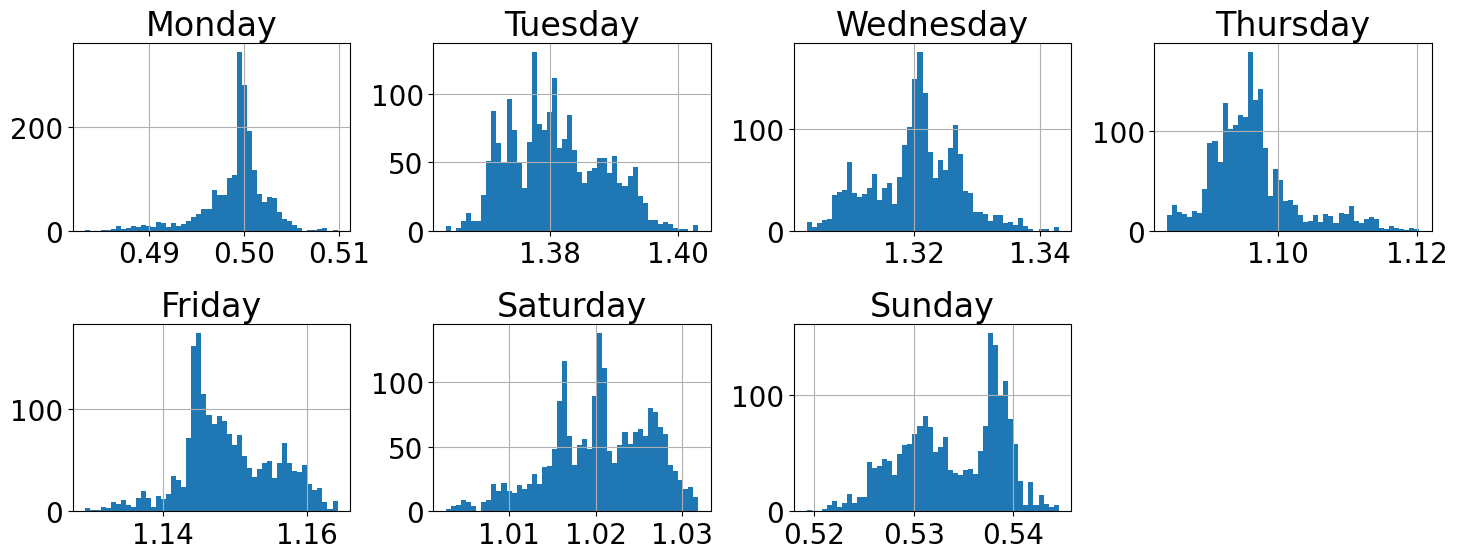

In [6]:
plt.rcParams['font.size'] = '20'

start_date = min(uk_df['Date']); start_index = start_date.weekday() - 1
output_bias = [np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 1) for i in range(7)]

histos = output.hist([("bias_" + str((i - start_index) % 7)) for i in range(7)], bins=50, figsize=(15, 6), layout=(2,4));
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    histos.flatten()[i].set_title(weekdays[i])
plt.gcf().patch.set_facecolor('white'); plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
# plt.savefig(images_path + f"biases_only_posterior_UK_newDeaths28DaysByPublishDate_It_{sample_num}_chains_{chain_num}_win_2.png")

for i in range(7):
    mean = np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 3)
    std = np.round(np.std(output['bias_' + str((i - start_index) % 7)]), 3)
    print(f"Bias_{i}: {mean} +/- {std}")

In [7]:
print(start_index)

-1


701


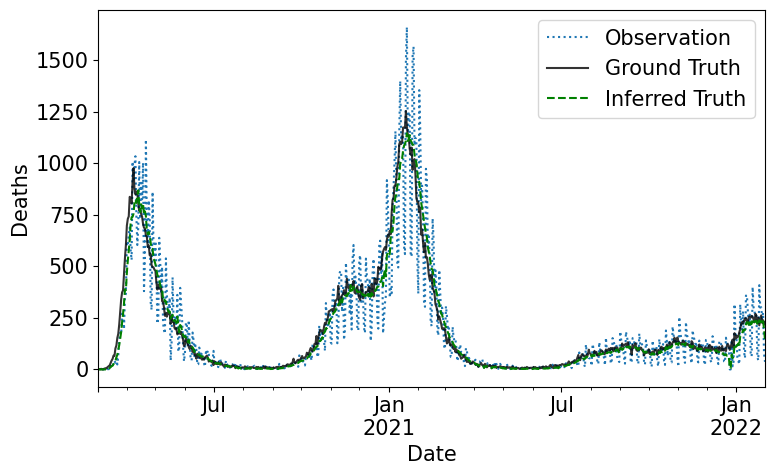

In [8]:
plt.rcParams['font.size'] = '15'
predicted_truth = []  
print(time_steps)

for index in range(1, time_steps + 1):
    predicted_truth.append(np.mean(output['I_' + str(index)]))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(8,5))

uk_df.plot(x='Date', y='newDeaths28DaysByPublishDate', ax=ax, color='tab:blue', label = 'Observation', linestyle = 'dotted')
uk_df.plot(x='Date', y='newDeaths28DaysByDeathDate', ax=ax, color='black', label = 'Ground Truth', alpha=0.8)
ax.plot(uk_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')

ax.set_xticks(ax.get_xticks()[::2]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Deaths")
plt.legend(); plt.tight_layout()
# plt.savefig(images_path + f"biased_reconstruction_UK_newDeaths28DaysByPublishDate_It_{sample_num}_chains_{chain_num}.png")

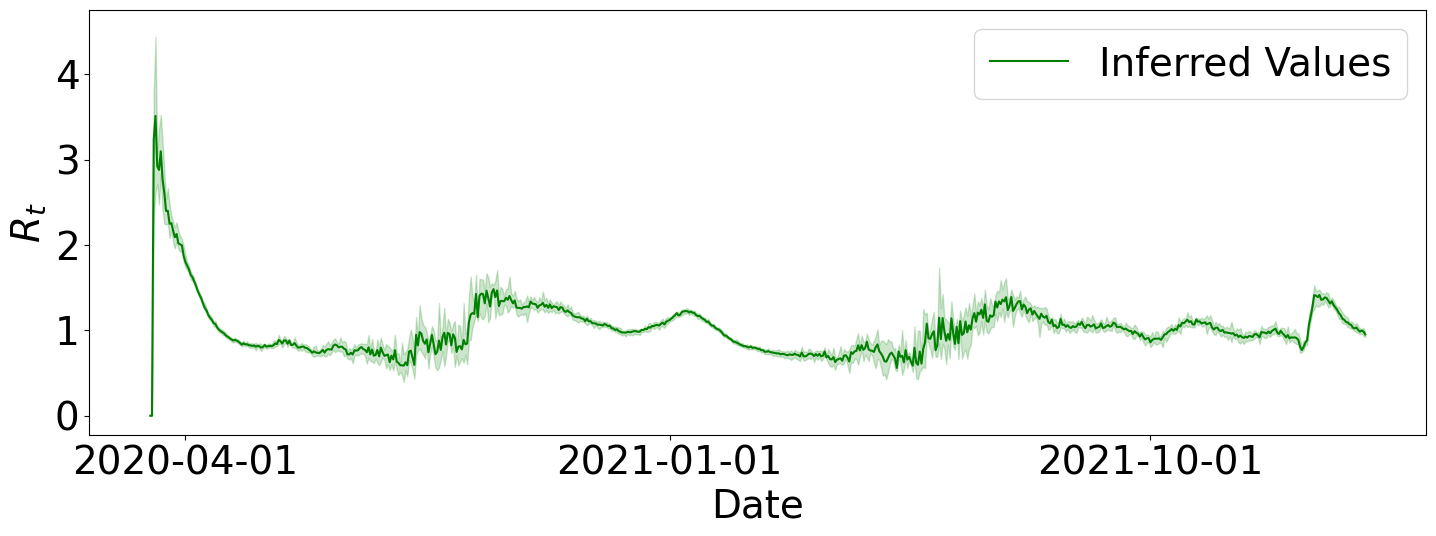

In [9]:
plt.rcParams['font.size'] = '28'; interval_range = 95; window = 10
predicted_R = []; upper_R = []; lower_R = []
percentile = (100-interval_range) / 2


for index in range(1, time_steps+1):
    predicted_R.append(np.mean(output['R_' + str(index)]))
    upper_R.append(np.percentile(output['R_' + str(index)], 100-percentile))
    lower_R.append(np.percentile(output['R_' + str(index)], percentile))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(15, 6))

ax.plot(uk_df['Date'][window:], predicted_R[window:], color='green', label = 'Inferred Values')
ax.fill_between(uk_df['Date'][window:], lower_R[window:], upper_R[window:], color = 'green', alpha=0.2)
ax.set_ylim([ax.get_ylim()[0],ax.get_ylim()[1]*1.02])
ax.set_xticks(ax.get_xticks()[::3]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("$R_{t}$")
plt.legend(ncol=2); plt.tight_layout()
# plt.savefig(images_path + f"Rt_reconstruction_UK_newDeaths28DaysByPublishDate_It_{sample_num}_chains_{chain_num}_win_2.png")

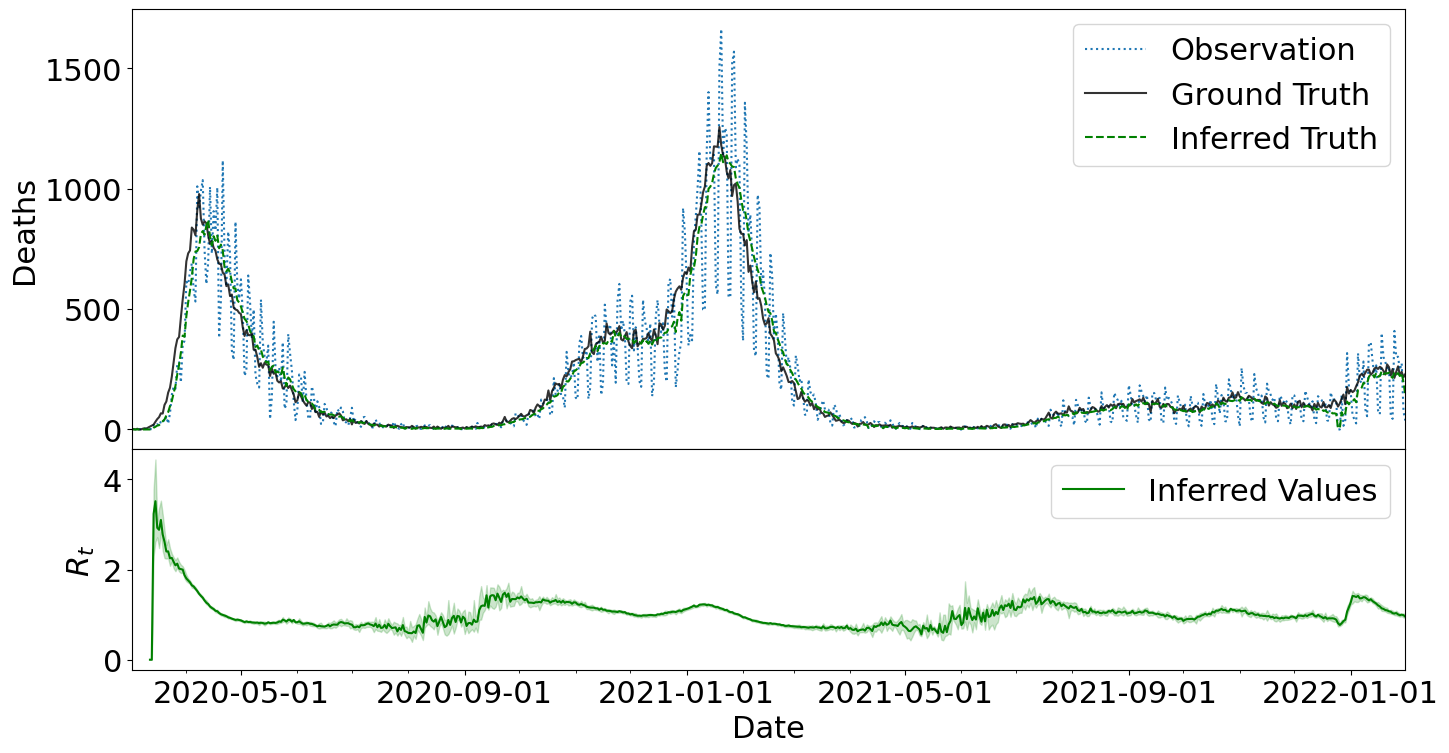

In [10]:
# combined plot for both timeseries and r
plt.rcParams['font.size'] = '22'
fig = plt.figure(figsize=(15, 8))

gs = fig.add_gridspec(2, 1,  height_ratios=(6, 3), hspace = 0)
                    #   left=0, right=1, bottom=0, top=1)
                    #   wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[0, 0])
ax_r = fig.add_subplot(gs[1, 0], sharex=ax)                     

uk_df.plot(x='Date', y='newDeaths28DaysByPublishDate', ax=ax, color='tab:blue', label = 'Observation', linestyle = 'dotted')
uk_df.plot(x='Date', y='newDeaths28DaysByDeathDate', ax=ax, color='black', label = 'Ground Truth', alpha=0.8)
ax.plot(uk_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')
ax.get_xaxis().set_visible(False); ax.legend(); ax.set_ylabel("Deaths");

ax_r.plot(uk_df['Date'][window:], predicted_R[window:], color='green', label = 'Inferred Values')
ax_r.fill_between(uk_df['Date'][window:], lower_R[window:], upper_R[window:], color = 'green', alpha=0.2)

ax_r.set_xticks(ax.get_xticks()[::2]); ax_r.legend()
plt.xlabel("Date"); plt.ylabel("$R_{t}$")

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(images_path + f"combined_series_UK_newDeaths28DaysByPublishDate_It_{sample_num}_chains_{chain_num}.png")

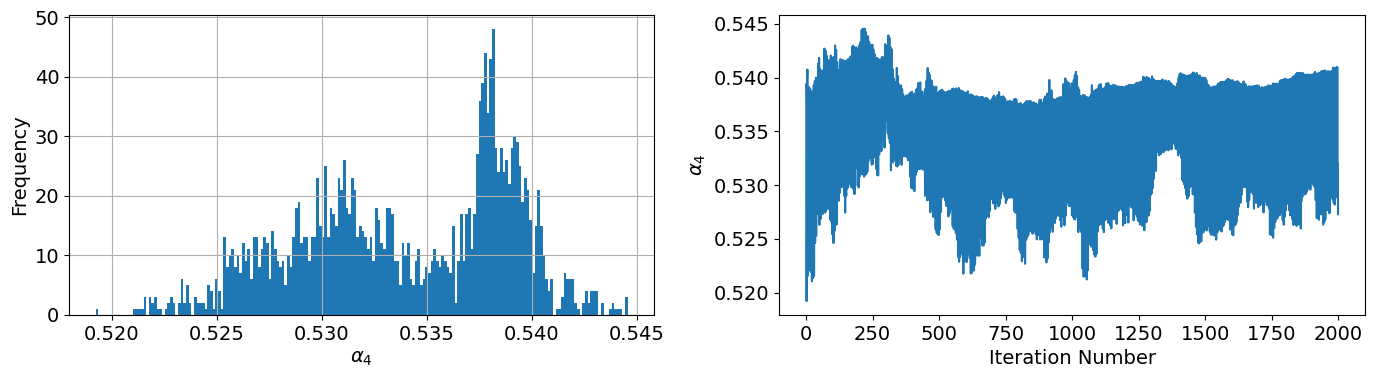

In [11]:
i = 0; bias_x = 'bias_' + str(i); bias_name = 'alpha{' + str(i) + '}'

plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(1, 2, figsize=(14,4))

histo = output.hist(bias_x, ax=axs[0], bins=200)
axs[0].set_xlabel(r'$\alpha_{4}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        index = output.index[output['Chain']==chain]
        # axs[1].plot(index % len(index), output[bias_x][output['Chain']==chain])
        axs[1].plot((pd.Series([x for x in range(len(index) + 1)]) % len(index + 1))[:-1],
                    (pd.concat([pd.Series([1.2]), output[bias_x][output['Chain']==chain]]))[:-1], alpha=0.7)
else:
    axs[1].plot(output.index, output[bias_x])
axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(r'$\alpha_{4}$'); axs[0].set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(images_path + f"{bias_x}_distribution_UK_newDeaths28DaysByPublishDate_It_{sample_num}_chains_{chain_num}.png")

RMS Residual for Biased data: 118.07
RMS Residual for Rolling Average data: 75.73
RMS Residual for Bayesian Inference data: 45.85


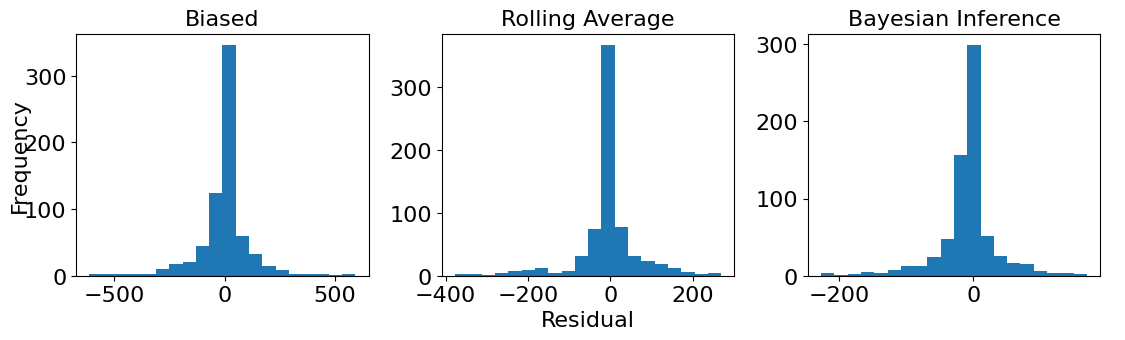

In [12]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

roll_ave_series = uk_df['newDeaths28DaysByPublishDate'].rolling(window=7).mean().bfill().ffill()
data_series = [uk_df['newDeaths28DaysByPublishDate'].fillna(0), roll_ave_series, predicted_truth]
labels = ['Biased', 'Rolling Average', 'Bayesian Inference']
font_size = 16

fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    residual = data_series[i] - uk_df['newDeaths28DaysByDeathDate']
    axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_residuals_UK_newDeaths28DaysByPublishDate_It_{sample_num}_chains_{chain_num}.png")

Expected lag for Biased data: -0.97 days
Expected lag for Rolling Average data: 0.57 days
Expected lag for Bayesian Inference data: -3.37 days


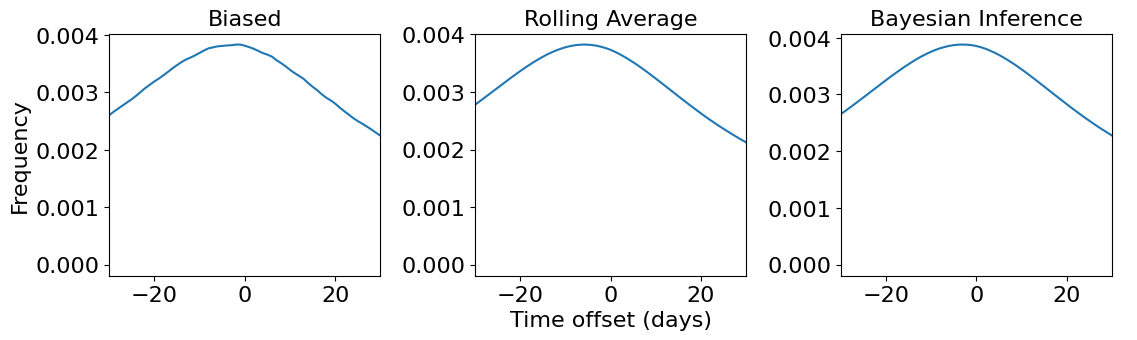

In [13]:
fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    cross_corr = np.correlate(uk_df['newDeaths28DaysByDeathDate'], data_series[i], mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    t_values = range(-len(uk_df['newDeaths28DaysByDeathDate']) + 1, len(uk_df['newDeaths28DaysByDeathDate']))
    expected_lag = np.dot(t_values, cross_corr)
    
    # cross_corr = np.divide(cross_corr, list(range(1,len(cross_corr)+2,2)) + list(range(1,len(cross_corr),2))[::-1])  # Normalise by number of contributing elements from timeseries
    axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].set_xlim(-30, 30); #axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_crosscorr_UK_newDeaths28DaysByPublishDate_It_{sample_num}_chains_{chain_num}.png")